In [ ]:
!pip install -U transformers accelerate bitsandbytes
!pip install -U langchain datasets sentence-transformers faiss-cpu nltk langchain-community
!pip install groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 827.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import re
import os
import json
import gc
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
from datasets import load_dataset, get_dataset_config_names
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.vectorstores.faiss import FAISS as FAISSVectorstore
from langchain.embeddings.base import Embeddings
from groq import Groq
nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)
!rm -r ~/.cache/huggingface/datasets/rungalileo__ragbench* 2>/dev/null || true

In [ ]:
import os
import shutil
from google.colab import drive

def save_vectorstore_to_drive(domain: str, local_base_path="vectorstores_bge", drive_folder="RAG_VectorStores"):
    """
    Save a FAISS vectorstore for a given domain to Google Drive as a ZIP archive.

    Args:
        domain (str): Domain name like "Legal", "Biomedical Research"
        local_base_path (str): Local folder where FAISS index is stored
        drive_folder (str): Folder in your Google Drive where data will be saved
    """
    # 1. Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    drive_path = f"/content/drive/MyDrive/{drive_folder}"
    os.makedirs(drive_path, exist_ok=True)

    # 2. Set paths
    domain_folder_name = domain.replace(" ", "_") + "_faiss"
    local_path = os.path.join(local_base_path, domain_folder_name)
    zip_filename = domain_folder_name + ".zip"
    zip_filepath = os.path.join("/content", zip_filename)

    # 3. Zip the vectorstore
    if os.path.exists(local_path):
        shutil.make_archive(zip_filepath.replace(".zip", ""), 'zip', local_path)
        print(f"Zipped vectorstore to {zip_filepath}")
    else:
        print(f"Vectorstore not found at {local_path}")
        return

    # 4. Move to Google Drive
    destination = os.path.join(drive_path, zip_filename)
    shutil.move(zip_filepath, destination)
    print(f"Copied ZIP to Google Drive: {destination}")

In [ ]:
class DatasetConfig:

    CONFIG_DOMAIN_MAP = {
        "covidqa": "Biomedical Research",
        "cuad": "Legal",
        "delucionqa": "Customer Support",
        "emanual": "Customer Support",
        "expertqa": "General Knowledge",
        "finqa": "Finance",
        "hagrid": "General Knowledge",
        "hotpotqa": "General Knowledge",
        "msmarco": "General Knowledge",
        "pubmedqa": "Biomedical Research",
        "tatqa": "Finance",
        "techqa": "Customer Support"
    }

    DOMAIN_CHUNKING_PARAMS = {
        "Biomedical Research": {
            "chunk_size": 250,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 15
        },
        "Legal": {
            "chunk_size": 384,
            "chunk_overlap": 64,
            "chunking_strategy": "small2big_chunking",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 8
        },
        "Customer Support": {
            "chunk_size": 300,
            "chunk_overlap": 50,
            "chunking_strategy": "recursive",
            "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
            "retrieval_k": 10
        },
        "General Knowledge": {
            "chunk_size": 350,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 10
        },
        "Finance": {
            "chunk_size": 250,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 20
        }
    }


def load_ragbench_datasets():
    """Load all RAGBench datasets"""
    print("Loading RAGBench datasets...")
    configs = get_dataset_config_names("rungalileo/ragbench")
    print(f"Available configs: {configs}")
    ragbench = {}
    for dataset in DatasetConfig.CONFIG_DOMAIN_MAP.keys():
        if dataset in configs:
            ragbench[dataset] = load_dataset("rungalileo/ragbench", dataset)
            print(f"Loaded {dataset}")
    return ragbench

def dataset_summary(ragbench):
    summary_data = []

    for config, domain in DatasetConfig.CONFIG_DOMAIN_MAP.items():
        if config in ragbench:
            dataset = ragbench[config]['test']
            summary_data.append({
                "Domain": domain,
                "Config": config,
                "Total Examples": len(dataset),
            })

    return pd.DataFrame(summary_data)

ragbench = load_ragbench_datasets()
summary_df = dataset_summary(ragbench)
print("\nDataset Summary:")
print(summary_df)

Loading RAGBench datasets...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Available configs: ['covidqa', 'cuad', 'delucionqa', 'emanual', 'expertqa', 'finqa', 'hagrid', 'hotpotqa', 'msmarco', 'pubmedqa', 'tatqa', 'techqa']


train-00000-of-00001.parquet:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/854k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/913k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1252 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/246 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/267 [00:00<?, ? examples/s]

Loaded covidqa


train-00000-of-00001.parquet:   0%|          | 0.00/56.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/510 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/510 [00:00<?, ? examples/s]

Loaded cuad


train-00000-of-00001.parquet:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/528k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/562k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/182 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/184 [00:00<?, ? examples/s]

Loaded delucionqa


train-00000-of-00001.parquet:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/288k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/305k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1054 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/132 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/132 [00:00<?, ? examples/s]

Loaded emanual


train-00000-of-00001.parquet:   0%|          | 0.00/22.7M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1621 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/203 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/203 [00:00<?, ? examples/s]

Loaded expertqa


train-00000-of-00001.parquet:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.94M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/8.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12502 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1766 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2294 [00:00<?, ? examples/s]

Loaded finqa


train-00000-of-00001.parquet:   0%|          | 0.00/9.42M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/322 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1318 [00:00<?, ? examples/s]

Loaded hagrid


train-00000-of-00001.parquet:   0%|          | 0.00/6.37M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1883 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/424 [00:00<?, ? examples/s]

Loaded hotpotqa


train-00000-of-00001.parquet:   0%|          | 0.00/9.13M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1870 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/397 [00:00<?, ? examples/s]

Loaded msmarco


train-00000-of-00001.parquet:   0%|          | 0.00/80.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19600 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2450 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2450 [00:00<?, ? examples/s]

Loaded pubmedqa


train-00000-of-00001.parquet:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26430 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3336 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3338 [00:00<?, ? examples/s]

Loaded tatqa


train-00000-of-00001.parquet:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1192 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/304 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

Loaded techqa

Dataset Summary:
                 Domain      Config  Total Examples
0   Biomedical Research     covidqa             246
1                 Legal        cuad             510
2      Customer Support  delucionqa             184
3      Customer Support     emanual             132
4     General Knowledge    expertqa             203
5               Finance       finqa            2294
6     General Knowledge      hagrid            1318
7     General Knowledge    hotpotqa             390
8     General Knowledge     msmarco             423
9   Biomedical Research    pubmedqa            2450
10              Finance       tatqa            3338
11     Customer Support      techqa             314


In [ ]:
class DocumentPreprocessor:

    @staticmethod
    def preprocess_document(text: str) -> str:
        """Clean and preprocess document text"""
        # Merge hyphenated line breaks
        text = text.replace("-\n", "")
        # Merge broken lines
        text = re.sub(r'\n(?=\w)', ' ', text)
        # Remove boilerplate content
        text = re.sub(r'Table of Contents.*?(\n|$)', '', text)
        text = re.sub(r'References\s*\n.*', '', text)
        text = re.sub(r'Page \d+ of \d+', '', text)
        text = re.sub(r'Copyright .*?\n', '', text)
        # Isolate headings
        text = re.sub(r'\n\d{0,2}\.?\s?[A-Z][^\n]{1,80}\n', r'\n\n\g<0>\n\n', text)
        # Normalize spacing
        return re.sub(r'\s+', ' ', text).strip()

class ChunkingStrategies:
    @staticmethod
    def small2big_chunking(text, chunk_size=350, overlap=64):
        sentences = sent_tokenize(text)
        chunks, current_chunk, current_length = [], [], 0
        for sentence in sentences:
            length = len(sentence.split())
            if current_length + length <= chunk_size:
                current_chunk.append(sentence)
                current_length += length
            else:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_length = length
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        return chunks

    @staticmethod
    def sentence_window_chunking(text, chunk_size=250, overlap=64):
        sentences = sent_tokenize(text)
        chunks = []
        i = 0
        while i < len(sentences):
            chunk, count = [], 0
            while i < len(sentences) and count + len(sentences[i].split()) <= chunk_size:
                chunk.append(sentences[i])
                count += len(sentences[i].split())
                i += 1
            if chunk:
                chunks.append(" ".join(chunk))
            i -= max(1, overlap // 10)
        return chunks

    @staticmethod
    def get_recursive_splitter(domain: str) -> RecursiveCharacterTextSplitter:
        """Get recursive text splitter for general domains"""
        params = DatasetConfig.DOMAIN_CHUNKING_PARAMS.get(
            domain, {"chunk_size": 350, "chunk_overlap": 64}
        )
        return RecursiveCharacterTextSplitter(
            chunk_size=params["chunk_size"],
            chunk_overlap=params["chunk_overlap"],
            separators=["\n\n", "\n", ".", " ", ""]
        )

def create_chunks_for_domain(domain, max_samples=None):
    """Create chunks for a specific domain with optional sample limit"""
    print(f"Creating chunks for domain: {domain}")

    # Get domain-specific configuration
    if domain not in DatasetConfig.DOMAIN_CHUNKING_PARAMS:
        available = list(DatasetConfig.DOMAIN_CHUNKING_PARAMS.keys())
        raise ValueError(f"Domain '{domain}' not found. Available: {available}")

    params = DatasetConfig.DOMAIN_CHUNKING_PARAMS[domain]
    strategy = params["chunking_strategy"]
    chunk_size = params["chunk_size"]
    chunk_overlap = params["chunk_overlap"]

    print(f"Using {strategy} strategy (size: {chunk_size}, overlap: {chunk_overlap})")
    if max_samples:
        print(f"Limiting to {max_samples} samples per dataset")

    configs = [k for k, v in DatasetConfig.CONFIG_DOMAIN_MAP.items() if v == domain]
    all_chunks = []

    for config in configs:
        if config not in ragbench:
            continue

        ds = ragbench[config]["test"]

        # Limit samples if max_samples is specified
        if max_samples is not None:
            ds = ds.select(range(min(max_samples, len(ds))))
            print(f"Processing {config} with {len(ds)} samples (limited from full dataset)")
        else:
            print(f"Processing {config} with {len(ds)} samples...")

        for doc_index, sample in enumerate(tqdm(ds, desc=f"Processing {config}")):
            for doc_pos, raw_doc in enumerate(sample.get("documents", [])):
                cleaned = DocumentPreprocessor.preprocess_document(raw_doc)

                # Choose chunking strategy based on domain configuration
                if strategy == "small2big":
                    chunks = ChunkingStrategies.small2big_chunking(
                        cleaned, chunk_size=chunk_size, overlap=chunk_overlap
                    )
                elif strategy == "sentence_window":
                    chunks = ChunkingStrategies.sentence_window_chunking(
                        cleaned, chunk_size=chunk_size, overlap=chunk_overlap
                    )
                else:  # recursive
                    splitter = ChunkingStrategies.get_recursive_splitter(domain)
                    chunks = splitter.split_text(cleaned)

                for chunk_index, chunk in enumerate(chunks):
                    if chunk.strip():
                        all_chunks.append({
                            "text": chunk,
                            "domain": domain,
                            "config": config,
                            "doc_id": doc_index,
                            "chunk_id": chunk_index
                        })

    # Save chunks
    filename = f"{domain.replace(' ', '_')}_chunks.json"
    with open(filename, "w") as f:
        json.dump(all_chunks, f, indent=2)

    print(f"Created {len(all_chunks)} chunks, saved to {filename}")
    return all_chunks

In [ ]:
class EmbeddingManager:

    def __init__(self, domain):
        if domain not in DatasetConfig.DOMAIN_CHUNKING_PARAMS:
            available = list(DatasetConfig.DOMAIN_CHUNKING_PARAMS.keys())
            raise ValueError(f"Domain '{domain}' not found. Available: {available}")

        self.domain = domain
        params = DatasetConfig.DOMAIN_CHUNKING_PARAMS[domain]
        model_name = params["embedding_model"]

        print(f"Loading domain-specific embedding model for {domain}")
        print(f"Model: {model_name}")

        self.model = SentenceTransformer(model_name)
        print(f" Loaded embedding model: {model_name}")

    def create_embeddings_batch(self, texts, batch_size=16):
        """Create embeddings in batches to manage memory"""
        all_embeddings = []
        print(f"Processing {len(texts)} texts in batches of {batch_size}")

        for i in tqdm(range(0, len(texts), batch_size), desc="Creating embeddings"):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = self.model.encode(
                batch_texts,
                show_progress_bar=False,
                normalize_embeddings=True
            )
            all_embeddings.extend(batch_embeddings)

            if i % (batch_size * 4) == 0:
                gc.collect()

        return all_embeddings

class BGEEmbeddings(Embeddings):
    """Custom embeddings wrapper for LangChain compatibility"""

    def __init__(self, model):
        self.model = model

    def embed_documents(self, texts):
        return self.model.encode(texts, normalize_embeddings=True).tolist()

    def embed_query(self, text):
        return self.model.encode([text], normalize_embeddings=True)[0].tolist()

def setup_faiss():
    """Setup FAISS with proper installation"""
    try:
        !pip uninstall -y faiss-gpu faiss-cpu faiss 2>/dev/null || true
        !pip install faiss-gpu
        import faiss
        print("FAISS-GPU installed successfully!")
        return True

    except ImportError:
        print("FAISS-GPU failed, trying FAISS-CPU...")
        try:
            !pip install faiss-cpu
            import faiss
            print("FAISS-CPU installed successfully!")
            return True
        except ImportError:
            print("FAISS installation failed!")
            return False

def create_vector_store(chunks, domain, embedding_manager):
    """Create and save vector store"""
    print(f"Creating vector store for {domain}...")
    docs = [
        Document(
            page_content=chunk["text"],
            metadata={k: chunk[k] for k in chunk if k != "text"}
        )
        for chunk in chunks
    ]

    # Create embeddings
    texts = [doc.page_content for doc in docs]
    embeddings = embedding_manager.create_embeddings_batch(texts)

    # Create vector store
    text_embedding_pairs = [(doc.page_content, embedding) for doc, embedding in zip(docs, embeddings)]

    try:
        vectorstore = FAISS.from_embeddings(text_embedding_pairs, embedding_manager.model)
        save_path = f"vectorstores_bge/{domain.replace(' ', '_')}_faiss"
        vectorstore.save_local(save_path)
        save_vectorstore_to_drive(domain)
        print(f"Vector store saved to {save_path}")
        return save_path
    except Exception as e:
        print(f"Failed to create vector store: {e}")
        return None

In [ ]:
class RetrievalManager:

    def __init__(self, domain, embedding_model, reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2"):
        self.domain = domain
        # Get domain-specific retrieval parameters
        params = DatasetConfig.DOMAIN_CHUNKING_PARAMS[domain]
        self.retrieval_k = params["retrieval_k"]
        self.embedding_model = embedding_model
        self.reranker = CrossEncoder(reranker_model)

        # Load vector store
        vectorstore_path = f"vectorstores_bge/{domain.replace(' ', '_')}_faiss"
        self.retriever = FAISSVectorstore.load_local(
            vectorstore_path,
            embeddings=BGEEmbeddings(embedding_model),
            allow_dangerous_deserialization=True
        ).as_retriever(search_type="similarity", search_kwargs={"k": self.retrieval_k})

        print(f"Retrieval manager initialized for {domain}")
        print(f"   Retrieval k: {self.retrieval_k}")

    def rerank_documents(self, query, docs):
        """Rerank documents using cross-encoder"""
        if not docs:
            return docs

        pairs = [[query, doc.page_content] for doc in docs]
        scores = self.reranker.predict(pairs)
        return [doc for doc, _ in sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)]

    def repack_documents(self, docs, max_tokens=512):
        """Repack documents to optimize token usage"""
        repacked_docs = []
        current_block = ""
        current_meta = []
        token_count = 0

        for doc in docs:
            tokens = len(doc.page_content.split())
            if token_count + tokens <= max_tokens:
                current_block += " " + doc.page_content
                current_meta.append(doc.metadata)
                token_count += tokens
            else:
                if current_block.strip():
                    repacked_docs.append(Document(
                        page_content=current_block.strip(),
                        metadata={"sources": current_meta}
                    ))
                current_block = doc.page_content
                current_meta = [doc.metadata]
                token_count = tokens

        if current_block.strip():
            repacked_docs.append(Document(
                page_content=current_block.strip(),
                metadata={"sources": current_meta}
            ))

        return repacked_docs

    def retrieve_and_rerank(self, query):
        """Complete retrieval and reranking pipeline"""
        # Retrieve documents
        retrieved = self.retriever.get_relevant_documents(query)

        # Rerank documents
        reranked = self.rerank_documents(query, retrieved)

        # Repack documents
        repacked = self.repack_documents(reranked)

        return repacked

In [ ]:
class LLMManager:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("GROQ_API_KEY", "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")
        self.client = Groq(api_key=api_key)
        print("LLM Manager initialized")

    def format_ragbench_judgment_prompt(self, question, documents, answer):
        formatted_docs = self._format_documents_with_keys(documents)
        formatted_answer = self._format_answer_with_keys(answer)

        return f"""You are evaluating the quality of a response to a question using supporting documents.

Your tasks:
1. Identify which document sentences (by key) are relevant to the question.
2. Identify which document sentences are actually used in the response.
3. Decide whether the response is overall supported by the documents.

Each document sentence is labeled with a unique key like '0a', '0b', etc.
Each answer sentence is labeled with a, b, c, etc.

Here are the inputs:

[QUESTION]
{question}

[DOCUMENTS]
{formatted_docs}

[ANSWER]
{formatted_answer}

Your response must be a **valid JSON object** like this:

{{
  "overall_supported": true,
  "all_relevant_sentence_keys": ["0a", "1b", "2c"],
  "all_utilized_sentence_keys": ["0a", "2c"]
}}

**Important**:
- Return only a valid JSON object with these three fields.
- Do not include any explanations or formatting like ```json or triple quotes.
- Do not leave any field empty; use an empty list [] if necessary.
"""

    def _format_documents_with_keys(self, documents):
        formatted = ""
        for doc_idx, doc in enumerate(documents):
            sentences = sent_tokenize(doc) if isinstance(doc, str) else sent_tokenize(doc.page_content)
            for sent_idx, sentence in enumerate(sentences):
                key = f"{doc_idx}{chr(97 + sent_idx)}."
                formatted += f"{key} {sentence.strip()}\n"
            formatted += "\n"
        return formatted.strip()

    def _format_answer_with_keys(self, answer):
        sentences = sent_tokenize(answer)
        formatted = ""
        for idx, sentence in enumerate(sentences):
            key = f"{chr(97 + idx)}."
            formatted += f"{key} {sentence.strip()}\n"
        return formatted.strip()

    def generate_answer(self, query, documents, model="qwen/qwen3-32b"):
        """Generate answer using Qwen3-32B with strict grounding"""
        context = "\n\n".join([doc.page_content for doc in documents])

        prompt = f"""You are a helpful assistant.

Answer the question using only the information provided in the context below.
- Cite multiple distinct examples if available.
- Use specific phrases from the context.
- If the context does not contain enough information to answer the question, reply exactly: \"Not found in context.\"


[CONTEXT]
{context}

[QUESTION]
{query}

[ANSWER]"""

        try:
            response = self.client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0.1,
                max_tokens=1024
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            return f"Error generating answer: {e}"

    def generate_judgment_ragbench_style(self, question, documents, answer, model="llama-3.1-8b-instant"):
        """Generate judgment using LLaMA3-8B by default (for RAGBench JSON style)"""
        prompt = self.format_ragbench_judgment_prompt(question, documents, answer)

        try:
            response = self.client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=2048,
                top_p=0.9
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"Error generating judgment: {e}"

    def generate_judgment(self, question, documents, model="llama-3.1-8b-instant"):
        """Simple score-based judgment (fallback method)"""
        context = "\n\n".join(documents) if isinstance(documents, list) else documents

        prompt = f"""Evaluate the context documents for answering the given question...

Context Relevance: [score]
Context Utilization: [score]
Completeness: [score]
Adherence: [score]

[CONTEXT]
{context}

[QUESTION]
{question}

Analyze step-by-step and provide your evaluation:"""

        try:
            response = self.client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=1024
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"Error generating judgment: {e}"

    def extract_ragbench_metrics_from_json(self, judgment_text):
        try:
            if judgment_text.strip().startswith('{'):
                judgment_data = json.loads(judgment_text)
                metrics = {}
                metrics['predicted_adherence'] = float(judgment_data.get('overall_supported', False))
                relevant_keys = judgment_data.get('all_relevant_sentence_keys', [])
                utilized_keys = judgment_data.get('all_utilized_sentence_keys', [])
                total_estimated_sentences = 20
                metrics['predicted_context_relevance'] = min(1.0, len(relevant_keys) / total_estimated_sentences)
                metrics['predicted_context_utilization'] = min(1.0, len(utilized_keys) / total_estimated_sentences)
                if len(relevant_keys) > 0:
                    intersection = set(relevant_keys).intersection(set(utilized_keys))
                    metrics['predicted_completeness'] = len(intersection) / len(relevant_keys)
                else:
                    metrics['predicted_completeness'] = 0.0
                return metrics
            else:
                return None
        except:
            return None

In [ ]:
class RAGPipeline:
    """Complete RAG pipeline"""

    def __init__(self, domain):
        available_domains = list(DatasetConfig.DOMAIN_CHUNKING_PARAMS.keys())
        if domain not in available_domains:
            raise ValueError(f"Invalid domain '{domain}'. Available domains: {available_domains}")

        self.domain = domain
        self.config = DatasetConfig.DOMAIN_CHUNKING_PARAMS[domain]

        print(f"RAG Pipeline initialized for domain: {domain}")
        print(f"Configuration: {self.config}")

        self.embedding_manager = None
        self.llm_manager = None
        self.retrieval_manager = None

        self.checkpoints = {
            'chunks_created': False,
            'embeddings_created': False,
            'vectorstore_created': False,
            'pipeline_ready': False
        }

    def check_existing_assets(self):
        domain_safe = self.domain.replace(' ', '_')
        chunks_file = f"{domain_safe}_chunks.json"
        if os.path.exists(chunks_file):
            self.checkpoints['chunks_created'] = True
            print(f"Found existing chunks: {chunks_file}")

        vectorstore_path = f"vectorstores_bge/{domain_safe}_faiss"
        if os.path.exists(vectorstore_path):
            self.checkpoints['vectorstore_created'] = True
            print(f"Found existing vector store: {vectorstore_path}")

        return self.checkpoints

    def setup_pipeline_incremental(self, force_rebuild=False, max_samples=None):
        print(f"\nSetting up pipeline for {self.domain} (incremental)...")

        if not force_rebuild:
            self.check_existing_assets()

        if not self.checkpoints['chunks_created'] or force_rebuild:
            print("Creating chunks...")
            if max_samples:
                print(f"Limiting document processing to {max_samples} samples")
            chunks = create_chunks_for_domain(self.domain, max_samples=max_samples)
            self.checkpoints['chunks_created'] = True
        else:
            print("Skipping chunk creation (already exists)")
            domain_safe = self.domain.replace(' ', '_')
            with open(f"{domain_safe}_chunks.json", "r") as f:
                chunks = json.load(f)

        if not setup_faiss():
            raise RuntimeError("Failed to setup FAISS")

        self.embedding_manager = EmbeddingManager(self.domain)

        if not self.checkpoints['vectorstore_created'] or force_rebuild:
            print("Creating vector store...")
            vectorstore_path = create_vector_store(chunks, self.domain, self.embedding_manager)
            if not vectorstore_path:
                raise RuntimeError("Failed to create vector store")
            self.checkpoints['vectorstore_created'] = True
        else:
            print("Skipping vector store creation (already exists)")

        print("Initializing retrieval manager...")
        self.retrieval_manager = RetrievalManager(self.domain, self.embedding_manager.model)

        print("Initializing LLM manager...")
        self.llm_manager = LLMManager()

        self.checkpoints['pipeline_ready'] = True
        print("Pipeline setup complete (incremental)")

        return self.checkpoints

    def run_generation_pipeline(self, output_file=None, max_samples=None):
        if not self.retrieval_manager:
            print("Pipeline not ready, setting up incrementally...")
            self.setup_pipeline_incremental(max_samples=max_samples)

        if output_file is None:
            output_file = f"{self.domain.replace(' ', '_').lower()}_with_generation.jsonl"

        if os.path.exists(output_file):
            print(f"Generation file already exists: {output_file}. Skipping generation.")
            return output_file

        configs = [k for k, v in DatasetConfig.CONFIG_DOMAIN_MAP.items() if v == self.domain]
        results = []

        for config in configs:
            if config not in ragbench:
                continue

            ds = ragbench[config]["test"]

            if max_samples is not None:
                ds = ds.select(range(min(max_samples, len(ds))))
                print(f"Processing {config} with {len(ds)} samples (limited from full dataset)")
            else:
                print(f"Processing {config} with {len(ds)} samples...")

            for sample in tqdm(ds, desc=f"Generating answers for {config}"):
                question = sample["question"]

                try:
                    ground_truth = {
                        "true_context_relevance": sample.get("relevance_score", None),
                        "true_context_utilization": sample.get("utilization_score", None),
                        "true_completeness": sample.get("completeness_score", None),
                        "true_adherence": float(sample.get("adherence_score", False)) if sample.get("adherence_score") is not None else None
                    }

                    documents = self.retrieval_manager.retrieve_and_rerank(question)
                    answer = self.llm_manager.generate_answer(question, documents, model="qwen/qwen3-32b")

                    results.append({
                        "domain": self.domain,
                        "config": config,
                        "question": question,
                        "retrieved_docs": [doc.page_content for doc in documents],
                        "generated_answer": answer,
                        **ground_truth
                    })

                except Exception as e:
                    print(f"Error processing question: {e}")
                    results.append({
                        "domain": self.domain,
                        "config": config,
                        "question": question,
                        "retrieved_docs": [],
                        "generated_answer": f"Error: {e}",
                        "true_context_relevance": None,
                        "true_context_utilization": None,
                        "true_completeness": None,
                        "true_adherence": None
                    })

        with open(output_file, "w") as f:
            for result in results:
                f.write(json.dumps(result) + "\n")

        print(f"Generation complete: {len(results)} results saved to {output_file}")
        return output_file

    def run_judgment_pipeline(self, input_file, output_file=None):
        if output_file is None:
            output_file = input_file.replace("generation", "judgment")

        if os.path.exists(output_file):
            print(f"Judgment file already exists: {output_file}. Skipping judgment.")
            return output_file

        if not os.path.exists(input_file):
            raise FileNotFoundError(f"Input file {input_file} does not exist")

        results = []
        success_count = 0
        fail_count = 0

        with open(input_file, "r") as f:
            for line in tqdm(f, desc="Running judgments"):
                row = json.loads(line)
                question = row.get("question", "")
                documents = row.get("retrieved_docs", [])
                answer = row.get("generated_answer", "")
                if not question.strip() or not documents or not answer.strip():
                    judgment = "Error: Empty input"
                    fail_count += 1
                else:
                    try:
                        judgment = self.llm_manager.generate_judgment_ragbench_style(question, documents, answer, model="llama-3.1-8b-instant")
                        success_count += 1
                    except Exception as e:
                        judgment = f"Error: {str(e)}"
                        fail_count += 1
                row["generated_judgement"] = judgment
                results.append(row)

        with open(output_file, "w") as f:
            for row in results:
                f.write(json.dumps(row) + "\n")

        print(f"Judgments complete: {len(results)} results saved to {output_file}")
        print(f"   Successful: {success_count} | Failed: {fail_count}")
        return output_file

In [ ]:
class EvaluationMetrics:

    @staticmethod
    def extract_metric_score(text, metric):
        """
        Extract a numeric metric score (e.g. "Completeness: 0.85") from a string.
        """
        if not text or not isinstance(text, str):
            return None

        patterns = [
            fr"{metric}:\s*([0-9]*\.?[0-9]+)",
            fr"{metric}\s*[:=]\s*([0-9]*\.?[0-9]+)",
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                try:
                    return float(match.group(1))
                except ValueError:
                    continue
        return None

    @staticmethod
    def extract_ragbench_metrics_from_json(judgment_text):
        """
        Extract structured metrics from RAGBench-format JSON string.
        """
        try:
            if judgment_text.strip().startswith('{'):
                judgment_data = json.loads(judgment_text)

                metrics = {}
                metrics['predicted_adherence'] = float(judgment_data.get('overall_supported', False))

                relevant_keys = judgment_data.get('all_relevant_sentence_keys', [])
                utilized_keys = judgment_data.get('all_utilized_sentence_keys', [])
                total_estimated_sentences = 20

                metrics['predicted_context_relevance'] = min(1.0, len(relevant_keys) / total_estimated_sentences)
                metrics['predicted_context_utilization'] = min(1.0, len(utilized_keys) / total_estimated_sentences)

                if len(relevant_keys) > 0:
                    intersection = set(relevant_keys).intersection(set(utilized_keys))
                    metrics['predicted_completeness'] = len(intersection) / len(relevant_keys)
                else:
                    metrics['predicted_completeness'] = 0.0

                return metrics
            else:
                return None
        except:
            return None

    @staticmethod
    def calculate_rmse(y_true, y_pred):
        """
        Compute Root Mean Squared Error (RMSE) with missing value handling.
        """
        mask = ~(pd.isna(y_true) | pd.isna(y_pred))
        if mask.sum() == 0:
            return None
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return np.sqrt(mse)

    @staticmethod
    def calculate_auc(y_true, y_pred, threshold=0.5):
        """
        Compute Area Under ROC Curve (AUC-ROC) with binary conversion and validation.
        """
        mask = ~(pd.isna(y_true) | pd.isna(y_pred))
        if mask.sum() == 0:
            return None

        y_true_clean = y_true[mask]
        y_pred_clean = y_pred[mask]
        y_true_binary = (y_true_clean > threshold).astype(int)

        if len(np.unique(y_true_binary)) < 2:
            return None

        try:
            return roc_auc_score(y_true_binary, y_pred_clean)
        except Exception:
            return None

    def evaluate_judgments(self, judgment_file):
        """
        Evaluate LLM judgments against ground truth metrics in a JSONL file.
        Returns a dictionary of RMSE, AUC-ROC, and coverage for each metric.
        """
        print("\nEvaluating against RAGBench ground truth...")

        with open(judgment_file, "r") as f:
            data = [json.loads(line) for line in f]

        df = pd.DataFrame(data)
        metrics = ["Context Relevance", "Context Utilization", "Completeness", "Adherence"]

        for metric in metrics:
            metric_key = metric.lower().replace(' ', '_')
            df[f"pred_{metric_key}"] = None

            for idx, row in df.iterrows():
                judgment = row.get("generated_judgement", "")
                json_metrics = self.extract_ragbench_metrics_from_json(judgment)

                if json_metrics:
                    pred_key = f"predicted_{metric_key}"
                    if pred_key in json_metrics:
                        df.at[idx, f"pred_{metric_key}"] = json_metrics[pred_key]
                    else:
                        print(f"[Warning] Missing key '{pred_key}' in JSON metrics for row {idx}")
                else:
                    score = self.extract_metric_score(judgment, metric)
                    df.at[idx, f"pred_{metric_key}"] = score
                    if score is None:
                        print(f"[Warning] Could not extract '{metric}' from judgment text in row {idx}")

        print("\nPreview of predicted and true metrics:")
        display_cols = [f"true_{m.lower().replace(' ', '_')}" for m in metrics] + \
                       [f"pred_{m.lower().replace(' ', '_')}" for m in metrics]
        print(df[display_cols].head(10).to_string(index=False))

        results = {}

        for metric in metrics:
            metric_key = metric.lower().replace(' ', '_')
            true_col = f"true_{metric_key}"
            pred_col = f"pred_{metric_key}"

            if true_col in df.columns and pred_col in df.columns:
                y_true = df[true_col]
                y_pred = df[pred_col]

                rmse = self.calculate_rmse(y_true, y_pred)
                auc = self.calculate_auc(y_true, y_pred)
                valid_mask = ~(pd.isna(y_true) | pd.isna(y_pred))
                valid_count = valid_mask.sum()

                results[metric] = {
                    "RMSE": rmse,
                    "AUC-ROC": auc,
                    "Valid_Predictions": valid_count,
                    "Total_Samples": len(df),
                    "Coverage": valid_count / len(df) * 100
                }
            else:
                results[metric] = {
                    "RMSE": None,
                    "AUC-ROC": None,
                    "Valid_Predictions": 0,
                    "Total_Samples": len(df),
                    "Coverage": 0.0
                }

        return results

    def print_evaluation_results(self, results):
        """
        Display evaluation metrics in a structured format.
        """
        print("\n" + "=" * 60)
        print("RAGBENCH EVALUATION RESULTS")
        print("=" * 60)

        for metric, scores in results.items():
            print(f"\n{metric}:")
            print("-" * 30)
            if scores["RMSE"] is not None:
                print(f"  RMSE: {scores['RMSE']:.4f}")
            else:
                print("  RMSE: Not computable")

            if scores["AUC-ROC"] is not None:
                print(f"  AUC-ROC: {scores['AUC-ROC']:.4f}")
            else:
                print("  AUC-ROC: Not computable")

            print(f"  Valid Predictions: {scores['Valid_Predictions']} / {scores['Total_Samples']}")
            print(f"  Coverage: {scores['Coverage']:.1f}%")

In [ ]:
def main(domain, resume_mode=True, force_rebuild=False, max_samples=None):
    """Main execution function with domain parameter and resume capability"""
    quick_test = max_samples is not None

    print(f"Starting RAG Pipeline Execution for {domain}")
    print(f"Resume mode: {resume_mode}")
    print(f"Force rebuild: {force_rebuild}")
    if quick_test:
        print(f"Quick test mode: True (max {max_samples} samples)")
    else:
        print("Full dataset mode")
    print("="*60)

    # Validate domain
    available_domains = list(DatasetConfig.DOMAIN_CHUNKING_PARAMS.keys())
    if domain not in available_domains:
        print(f"Invalid domain: '{domain}'")
        print(f"Available domains: {available_domains}")
        return None

    # Initialize pipeline with domain
    rag = RAGPipeline(domain=domain)

    # List existing assets
    rag.list_existing_assets()

    # Setup pipeline
    if resume_mode and not force_rebuild:
        print("\nAttempting quick resume...")
        if rag.quick_resume():
            print("Successfully resumed from existing assets")
        else:
            print("Quick resume failed, running incremental setup...")
            rag.setup_pipeline_incremental(force_rebuild=False, max_samples=max_samples)
    else:
        print("\nRunning pipeline setup...")
        if force_rebuild:
            rag.setup_pipeline_incremental(force_rebuild=True, max_samples=max_samples)
        else:
            rag.setup_pipeline_incremental(force_rebuild=False, max_samples=max_samples)

    # Test pipeline
    print("\nTesting pipeline...")
    test_result = rag.test_pipeline()

    if test_result:
        print("Pipeline test successful!")
        print(f"Used {test_result['config_used']['chunking_strategy']} chunking")
        print(f"Used {test_result['config_used']['embedding_model']} embeddings")
        print(f"Used k={test_result['config_used']['retrieval_k']} retrieval")
        print(f"Sample answer: {test_result['answer'][:200]}...")

    # Run generation pipeline
    if quick_test:
        print(f"\nRunning quick test with {max_samples} samples...")
        judgment_file = rag.run_quick_test(max_samples=max_samples)
    else:
        print("\nRunning full generation pipeline...")
        generation_file = rag.run_generation_pipeline()

        # Run judgment pipeline
        print("\nRunning judgment pipeline...")
        judgment_file = rag.run_judgment_pipeline(generation_file)

        # Evaluate results
        print("\nEvaluating results...")
        evaluator = EvaluationMetrics()
        results = evaluator.evaluate_judgments(judgment_file)
        evaluator.print_evaluation_results(results)

    print(f"\nPipeline execution complete for {domain}!")
    print(f"Final results saved to: {judgment_file}")

    return rag

In [ ]:
def run_pipeline_for_domains(domains, max_samples=None):
    for domain in domains:
        print("\n" + "="*60)
        print(f"Starting domain: {domain}")
        print("="*60)

        try:
            rag = RAGPipeline(domain)
            rag.quick_resume()

            domain_safe = domain.replace(' ', '_').lower()
            gen_file = f"{domain_safe}_with_generation.jsonl"
            judge_file = f"{domain_safe}_with_judgment.jsonl"

            if os.path.exists(gen_file):
                print(f"Found generation file: {gen_file}. Skipping generation.")
            else:
                print(f"Running generation for {domain}...")
                rag.run_generation_pipeline(output_file=gen_file, max_samples=max_samples)

            if os.path.exists(judge_file):
                print(f"Found judgment file: {judge_file}. Skipping judgment.")
            else:
                print(f"Running judgment for {domain}...")
                rag.run_judgment_pipeline(input_file=gen_file, output_file=judge_file)

        except Exception as e:
            print(f"Error processing {domain}: {e}")
            continue

    print("\nAll selected domains processed.")

In [ ]:
if __name__ == "__main__":
    domains_to_process = ["General Knowledge", "Customer Support", "Biomedical Research","Finance","Legal"]
#    domains_to_process = ["Biomedical Research"]

    for domain in domains_to_process:
        print("\n" + "=" * 60)
        print(f"Starting domain: {domain}")
        print("=" * 60)

        try:
            rag_pipeline = RAGPipeline(domain=domain)
            rag_pipeline.setup_pipeline_incremental(force_rebuild=False, max_samples=200)

            generation_file = rag_pipeline.run_generation_pipeline(
                output_file=f"{domain.replace(' ', '_').lower()}_with_generation.jsonl",
                max_samples=200
            )

            judgment_file = rag_pipeline.run_judgment_pipeline(
                input_file=generation_file,
                output_file=f"{domain.replace(' ', '_').lower()}_with_judgment.jsonl"
            )

            print("\nEvaluating results...")
            evaluator = EvaluationMetrics()
            results = evaluator.evaluate_judgments(judgment_file)
            evaluator.print_evaluation_results(results)

            print(f"\nEvaluation complete! Results saved to: {judgment_file}")

        except Exception as e:
            print(f"Error processing {domain}: {e}")


Starting domain: General Knowledge
RAG Pipeline initialized for domain: General Knowledge
Configuration: {'chunk_size': 350, 'chunk_overlap': 64, 'chunking_strategy': 'recursive', 'embedding_model': 'BAAI/bge-large-en', 'retrieval_k': 10}

Setting up pipeline for General Knowledge (incremental)...
Creating chunks...
Limiting document processing to 200 samples
Creating chunks for domain: General Knowledge
Using recursive strategy (size: 350, overlap: 64)
Limiting to 200 samples per dataset
Processing expertqa with 200 samples (limited from full dataset)


Processing expertqa: 100%|██████████| 200/200 [00:00<00:00, 546.86it/s]


Processing hagrid with 200 samples (limited from full dataset)


Processing hagrid: 100%|██████████| 200/200 [00:00<00:00, 1684.60it/s]


Processing hotpotqa with 200 samples (limited from full dataset)


Processing hotpotqa: 100%|██████████| 200/200 [00:00<00:00, 1544.92it/s]


Processing msmarco with 200 samples (limited from full dataset)


Processing msmarco: 100%|██████████| 200/200 [00:00<00:00, 1040.49it/s]


Created 13542 chunks, saved to General_Knowledge_chunks.json
Found existing installation: faiss-cpu 1.11.0.post1
Uninstalling faiss-cpu-1.11.0.post1:
  Successfully uninstalled faiss-cpu-1.11.0.post1
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU failed, trying FAISS-CPU...
  Using cached faiss_cpu-1.11.0.post1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.0 kB)
Using cached faiss_cpu-1.11.0.post1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (31.3 MB)
FAISS-CPU installed successfully!
Loading domain-specific embedding model for General Knowledge
Model: BAAI/bge-large-en


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

 Loaded embedding model: BAAI/bge-large-en
Creating vector store...
Creating vector store for General Knowledge...
Processing 13542 texts in batches of 16


Creating embeddings:   0%|          | 0/847 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Creating embeddings: 100%|██████████| 847/847 [05:08<00:00,  2.75it/s]


Failed to create vector store: mount failed
Error processing General Knowledge: Failed to create vector store

Starting domain: Customer Support
RAG Pipeline initialized for domain: Customer Support
Configuration: {'chunk_size': 300, 'chunk_overlap': 50, 'chunking_strategy': 'recursive', 'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2', 'retrieval_k': 10}

Setting up pipeline for Customer Support (incremental)...
Creating chunks...
Limiting document processing to 200 samples
Creating chunks for domain: Customer Support
Using recursive strategy (size: 300, overlap: 50)
Limiting to 200 samples per dataset
Processing delucionqa with 184 samples (limited from full dataset)


Processing delucionqa: 100%|██████████| 184/184 [00:00<00:00, 924.75it/s]


Processing emanual with 132 samples (limited from full dataset)


Processing emanual: 100%|██████████| 132/132 [00:00<00:00, 1076.87it/s]


Processing techqa with 200 samples (limited from full dataset)


Processing techqa: 100%|██████████| 200/200 [00:00<00:00, 296.01it/s]


Created 21426 chunks, saved to Customer_Support_chunks.json
Found existing installation: faiss-cpu 1.11.0.post1
Uninstalling faiss-cpu-1.11.0.post1:
  Successfully uninstalled faiss-cpu-1.11.0.post1
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU installed successfully!
Loading domain-specific embedding model for Customer Support
Model: sentence-transformers/all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Loaded embedding model: sentence-transformers/all-MiniLM-L6-v2
Creating vector store...
Creating vector store for Customer Support...
Processing 21426 texts in batches of 16


Creating embeddings: 100%|██████████| 1340/1340 [03:06<00:00,  7.17it/s]


Mounted at /content/drive
Zipped vectorstore to /content/Customer_Support_faiss.zip
Copied ZIP to Google Drive: /content/drive/MyDrive/RAG_VectorStores/Customer_Support_faiss.zip
Vector store saved to vectorstores_bge/Customer_Support_faiss
Initializing retrieval manager...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Retrieval manager initialized for Customer Support
   Retrieval k: 10
Initializing LLM manager...
LLM Manager initialized
Pipeline setup complete (incremental)
Processing delucionqa with 184 samples (limited from full dataset)


Generating answers for delucionqa:   0%|          | 0/184 [00:00<?, ?it/s]/tmp/ipython-input-1755601054.py:65: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved = self.retriever.get_relevant_documents(query)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for delucionqa:   1%|          | 1/184 [00:01<03:32,  1.16s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for delucionqa:   1%|          | 2/184 [00:01<02:39,  1.14it/s]/usr/loc

Processing emanual with 132 samples (limited from full dataset)


Generating answers for emanual:   0%|          | 0/132 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for emanual:   1%|          | 1/132 [00:00<01:19,  1.65it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for emanual:   2%|▏         | 2/132 [00:01<01:55,  1.13it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for emanual:   2%|▏         |

Processing techqa with 200 samples (limited from full dataset)


Generating answers for techqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for techqa:   0%|          | 1/200 [00:02<07:38,  2.31s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for techqa:   1%|          | 2/200 [00:03<04:47,  1.45s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for techqa:   2%|▏         | 3/2

Generation complete: 516 results saved to customer_support_with_generation.jsonl


Running judgments: 516it [08:20,  1.03it/s]


Judgments complete: 516 results saved to customer_support_with_judgment.jsonl
   Successful: 516 | Failed: 0

Evaluating results...

Evaluating against RAGBench ground truth...
[Warning] Could not extract 'Context Relevance' from judgment text in row 78
[Warning] Could not extract 'Context Relevance' from judgment text in row 245
[Warning] Could not extract 'Context Relevance' from judgment text in row 311
[Warning] Could not extract 'Context Relevance' from judgment text in row 372
[Warning] Could not extract 'Context Utilization' from judgment text in row 78
[Warning] Could not extract 'Context Utilization' from judgment text in row 245
[Warning] Could not extract 'Context Utilization' from judgment text in row 311
[Warning] Could not extract 'Context Utilization' from judgment text in row 372
[Warning] Could not extract 'Completeness' from judgment text in row 78
[Warning] Could not extract 'Completeness' from judgment text in row 245
[Warning] Could not extract 'Completeness' from 

Processing covidqa: 100%|██████████| 200/200 [00:00<00:00, 1333.75it/s]


Processing pubmedqa with 200 samples (limited from full dataset)


Processing pubmedqa: 100%|██████████| 200/200 [00:00<00:00, 1368.29it/s]


Created 5152 chunks, saved to Biomedical_Research_chunks.json
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU installed successfully!
Loading domain-specific embedding model for Biomedical Research
Model: BAAI/bge-large-en
 Loaded embedding model: BAAI/bge-large-en
Creating vector store...
Creating vector store for Biomedical Research...
Processing 5152 texts in batches of 16


Creating embeddings:   0%|          | 0/322 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Creating embeddings: 100%|██████████| 322/322 [01:39<00:00,  3.25it/s]


Mounted at /content/drive
Zipped vectorstore to /content/Biomedical_Research_faiss.zip
Copied ZIP to Google Drive: /content/drive/MyDrive/RAG_VectorStores/Biomedical_Research_faiss.zip
Vector store saved to vectorstores_bge/Biomedical_Research_faiss
Initializing retrieval manager...
Retrieval manager initialized for Biomedical Research
   Retrieval k: 15
Initializing LLM manager...
LLM Manager initialized
Pipeline setup complete (incremental)
Processing covidqa with 200 samples (limited from full dataset)


Generating answers for covidqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for covidqa:   0%|          | 1/200 [00:02<09:06,  2.75s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for covidqa:   1%|          | 2/200 [00:03<05:38,  1.71s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for covidqa:   2%|▏         |

Processing pubmedqa with 200 samples (limited from full dataset)


Generating answers for pubmedqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for pubmedqa:   0%|          | 1/200 [00:02<06:49,  2.06s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for pubmedqa:   1%|          | 2/200 [00:03<05:54,  1.79s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for pubmedqa:   2%|▏      

Generation complete: 400 results saved to biomedical_research_with_generation.jsonl


Running judgments: 400it [05:41,  1.17it/s]


Judgments complete: 400 results saved to biomedical_research_with_judgment.jsonl
   Successful: 400 | Failed: 0

Evaluating results...

Evaluating against RAGBench ground truth...
[Warning] Could not extract 'Context Relevance' from judgment text in row 36
[Warning] Could not extract 'Context Relevance' from judgment text in row 60
[Warning] Could not extract 'Context Relevance' from judgment text in row 103
[Warning] Could not extract 'Context Relevance' from judgment text in row 162
[Warning] Could not extract 'Context Relevance' from judgment text in row 176
[Warning] Could not extract 'Context Utilization' from judgment text in row 36
[Warning] Could not extract 'Context Utilization' from judgment text in row 60
[Warning] Could not extract 'Context Utilization' from judgment text in row 103
[Warning] Could not extract 'Context Utilization' from judgment text in row 162
[Warning] Could not extract 'Context Utilization' from judgment text in row 176
[Warning] Could not extract 'Compl

Processing finqa: 100%|██████████| 200/200 [00:00<00:00, 959.78it/s]


Processing tatqa with 200 samples (limited from full dataset)


Processing tatqa: 100%|██████████| 200/200 [00:00<00:00, 1524.82it/s]


Created 7019 chunks, saved to Finance_chunks.json
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU installed successfully!
Loading domain-specific embedding model for Finance
Model: BAAI/bge-large-en
 Loaded embedding model: BAAI/bge-large-en
Creating vector store...
Creating vector store for Finance...
Processing 7019 texts in batches of 16


Creating embeddings:   0%|          | 0/439 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Creating embeddings: 100%|██████████| 439/439 [02:59<00:00,  2.44it/s]


Mounted at /content/drive
Zipped vectorstore to /content/Finance_faiss.zip
Copied ZIP to Google Drive: /content/drive/MyDrive/RAG_VectorStores/Finance_faiss.zip
Vector store saved to vectorstores_bge/Finance_faiss
Initializing retrieval manager...
Retrieval manager initialized for Finance
   Retrieval k: 20
Initializing LLM manager...
LLM Manager initialized
Pipeline setup complete (incremental)
Processing finqa with 200 samples (limited from full dataset)


Generating answers for finqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for finqa:   0%|          | 1/200 [00:02<07:42,  2.33s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for finqa:   1%|          | 2/200 [00:04<07:36,  2.31s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for finqa:   2%|▏         | 3/200 [

Processing tatqa with 200 samples (limited from full dataset)


Generating answers for tatqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for tatqa:   0%|          | 1/200 [00:00<03:03,  1.09it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for tatqa:   1%|          | 2/200 [00:02<03:20,  1.01s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for tatqa:   2%|▏         | 3/200 [

Generation complete: 400 results saved to finance_with_generation.jsonl


Running judgments: 400it [11:45,  1.76s/it]


Judgments complete: 400 results saved to finance_with_judgment.jsonl
   Successful: 400 | Failed: 0

Evaluating results...

Evaluating against RAGBench ground truth...
[Warning] Could not extract 'Context Relevance' from judgment text in row 27
[Warning] Could not extract 'Context Relevance' from judgment text in row 32
[Warning] Could not extract 'Context Relevance' from judgment text in row 51
[Warning] Could not extract 'Context Relevance' from judgment text in row 59
[Warning] Could not extract 'Context Relevance' from judgment text in row 73
[Warning] Could not extract 'Context Relevance' from judgment text in row 87
[Warning] Could not extract 'Context Relevance' from judgment text in row 121
[Warning] Could not extract 'Context Relevance' from judgment text in row 123
[Warning] Could not extract 'Context Relevance' from judgment text in row 126
[Warning] Could not extract 'Context Relevance' from judgment text in row 146
[Warning] Could not extract 'Context Relevance' from judgm

Processing cuad: 100%|██████████| 200/200 [00:01<00:00, 148.70it/s]


Created 29874 chunks, saved to Legal_chunks.json
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU installed successfully!
Loading domain-specific embedding model for Legal
Model: BAAI/bge-large-en
 Loaded embedding model: BAAI/bge-large-en
Creating vector store...
Creating vector store for Legal...
Processing 29874 texts in batches of 16


Creating embeddings:   0%|          | 0/1868 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Creating embeddings: 100%|██████████| 1868/1868 [12:53<00:00,  2.41it/s]


Mounted at /content/drive
Zipped vectorstore to /content/Legal_faiss.zip
Copied ZIP to Google Drive: /content/drive/MyDrive/RAG_VectorStores/Legal_faiss.zip
Vector store saved to vectorstores_bge/Legal_faiss
Initializing retrieval manager...
Retrieval manager initialized for Legal
   Retrieval k: 8
Initializing LLM manager...
LLM Manager initialized
Pipeline setup complete (incremental)
Processing cuad with 200 samples (limited from full dataset)


Generating answers for cuad:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for cuad:   0%|          | 1/200 [00:00<02:54,  1.14it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for cuad:   1%|          | 2/200 [00:01<02:59,  1.10it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for cuad:   2%|▏         | 3/200 [00:0

Generation complete: 200 results saved to legal_with_generation.jsonl


Running judgments: 200it [01:55,  1.73it/s]

Judgments complete: 200 results saved to legal_with_judgment.jsonl
   Successful: 200 | Failed: 0

Evaluating results...

Evaluating against RAGBench ground truth...
[Warning] Could not extract 'Context Relevance' from judgment text in row 124
[Warning] Could not extract 'Context Utilization' from judgment text in row 124
[Warning] Could not extract 'Completeness' from judgment text in row 124
[Warning] Could not extract 'Adherence' from judgment text in row 124

Preview of predicted and true metrics:
 true_context_relevance  true_context_utilization  true_completeness  true_adherence pred_context_relevance pred_context_utilization pred_completeness pred_adherence
               0.010811                  0.005405           0.500000             1.0                    0.6                      0.1          0.083333            0.0
               1.000000                  0.000000           0.000000             1.0                    0.7                     0.55          0.785714           

In [ ]:
def run_batch_evaluation():
    import csv
    domains_to_process = ["General Knowledge", "Customer Support", "Biomedical Research","Finance","Legal"]
#    domains_to_process = ["Biomedical Research"]
    threshold = 0.75
    summary_rows = []

    for domain in domains_to_process:
        print("\n" + "=" * 60)
        print(f"Starting domain: {domain}")
        print("=" * 60)

        try:
            rag_pipeline = RAGPipeline(domain=domain)
            rag_pipeline.setup_pipeline_incremental(force_rebuild=False, max_samples=200)

            generation_file = rag_pipeline.run_generation_pipeline(
                output_file=f"{domain.replace(' ', '_').lower()}_with_generation.jsonl",
                max_samples=200
            )

            judgment_file = rag_pipeline.run_judgment_pipeline(
                input_file=generation_file,
                output_file=f"{domain.replace(' ', '_').lower()}_with_judgment.jsonl"
            )

            print("\nEvaluating results...")
            evaluator = EvaluationMetrics()
            results = evaluator.evaluate_judgments(judgment_file)
            evaluator.print_evaluation_results(results)

            row = {
                "Domain": domain,
                **{metric: scores["RMSE"] for metric, scores in results.items()},
                "Status": "PASS" if results["Adherence"]["RMSE"] <= (1 - threshold) else "FAIL"
            }
            summary_rows.append(row)

            print(f"\nEvaluation complete! Results saved to: {judgment_file}")

        except Exception as e:
            print(f"Error processing {domain}: {e}")
            summary_rows.append({"Domain": domain, "Status": "ERROR"})

    with open("rag_evaluation_summary.csv", "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=summary_rows[0].keys())
        writer.writeheader()
        writer.writerows(summary_rows)

    print("\nSummary of Evaluation (saved to rag_evaluation_summary.csv):")
    for row in summary_rows:
        print(row)

In [ ]:
def run_gradio_ui():
    import gradio as gr

    domains = ["General Knowledge", "Customer Support", "Biomedical Research","Finance","Legal"]

    domain_chunking_params = {
        "Biomedical Research": {
            "chunk_size": 250,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 15
        },
        "Legal": {
            "chunk_size": 384,
            "chunk_overlap": 64,
            "chunking_strategy": "small2big_chunking",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 8
        },
        "Customer Support": {
            "chunk_size": 300,
            "chunk_overlap": 50,
            "chunking_strategy": "recursive",
            "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
            "retrieval_k": 10
        },
        "General Knowledge": {
            "chunk_size": 350,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 10
        },
        "Finance": {
            "chunk_size": 250,
            "chunk_overlap": 64,
            "chunking_strategy": "recursive",
            "embedding_model": "BAAI/bge-large-en",
            "retrieval_k": 20
        }
    }


    rag_instances = {}

    def answer_question(domain, question):
        if not question.strip():
            return "Please enter a valid question.", ""

        try:
            if domain not in rag_instances:
                rag = RAGPipeline(domain)
                rag.setup_pipeline_incremental(force_rebuild=False, max_samples=100)
                rag_instances[domain] = rag
            else:
                rag = rag_instances[domain]

            documents = rag.retrieval_manager.retrieve_and_rerank(question)
            answer = rag.llm_manager.generate_answer(
                query=question,
                documents=documents,
                model="qwen/qwen3-32b"
            )
            context_preview = "\n\n".join([doc.page_content for doc in documents[:3]])
            return answer, context_preview

        except Exception as e:
            return f"Error: {e}", ""

    with gr.Blocks(theme=gr.themes.Soft()) as demo:
        gr.Markdown("# Real-World RAG Q&A System", elem_id="title")
        gr.Markdown("Ask a question grounded in domain-specific documents. Only answers backed by the data will be returned.")

        with gr.Row():
            domain_select = gr.Dropdown(domains, label="Select Domain", value="Biomedical Research", interactive=True)
            question_input = gr.Textbox(label="Your Question", lines=3, placeholder="Ask something like: How does AI work in legal systems?")

        submit_btn = gr.Button("Submit", variant="primary")
        answer_output = gr.Textbox(label="Generated Answer", lines=10, interactive=False)

        with gr.Accordion("Show Retrieved Documents (Debug)", open=False):
            context_output = gr.Textbox(label="Top Retrieved Context", lines=10, interactive=False)

        submit_btn.click(fn=answer_question, inputs=[domain_select, question_input], outputs=[answer_output, context_output])

    demo.launch(share=True)

In [ ]:
if __name__ == "__main__":
    #MODE = "gradio"  # Change to "batch" to run evaluation pipeline
    MODE = "batch"  # Change to "batch" to run evaluation pipeline

    if MODE == "gradio":
        run_gradio_ui()
    elif MODE == "batch":
        run_batch_evaluation()


Starting domain: General Knowledge
RAG Pipeline initialized for domain: General Knowledge
Configuration: {'chunk_size': 350, 'chunk_overlap': 64, 'chunking_strategy': 'recursive', 'embedding_model': 'BAAI/bge-large-en', 'retrieval_k': 10}

Setting up pipeline for General Knowledge (incremental)...
Found existing chunks: General_Knowledge_chunks.json
Found existing vector store: vectorstores_bge/General_Knowledge_faiss
Skipping chunk creation (already exists)
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
FAISS-GPU installed successfully!
Loading domain-specific embedding model for General Knowledge
Model: BAAI/bge-large-en
 Loaded embedding model: BAAI/bge-large-en
Skipping vector store creation (already exists)
Initializing retrieval manager...
Retrieval manager initialized for General Knowledge
   Retrieval k: 10
Initializing LLM manager...
LLM Manager initialized
Pipeline setup compl

Generating answers for expertqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for expertqa:   0%|          | 1/200 [00:01<06:11,  1.87s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for expertqa:   1%|          | 2/200 [00:03<05:19,  1.61s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for expertqa:   2%|▏      

Processing hagrid with 200 samples (limited from full dataset)


Generating answers for hagrid:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hagrid:   0%|          | 1/200 [00:01<03:42,  1.12s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hagrid:   1%|          | 2/200 [00:02<03:14,  1.02it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hagrid:   2%|▏         | 3/2

Processing hotpotqa with 200 samples (limited from full dataset)


Generating answers for hotpotqa:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hotpotqa:   0%|          | 1/200 [00:02<06:42,  2.02s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hotpotqa:   1%|          | 2/200 [00:02<04:26,  1.35s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for hotpotqa:   2%|▏      

Processing msmarco with 200 samples (limited from full dataset)


Generating answers for msmarco:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for msmarco:   0%|          | 1/200 [00:00<02:18,  1.43it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for msmarco:   1%|          | 2/200 [00:02<04:16,  1.30s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Generating answers for msmarco:   2%|▏         |

Generation complete: 800 results saved to general_knowledge_with_generation.jsonl


Running judgments: 800it [13:34,  1.02s/it]


Judgments complete: 800 results saved to general_knowledge_with_judgment.jsonl
   Successful: 800 | Failed: 0

Evaluating results...

Evaluating against RAGBench ground truth...
[Warning] Could not extract 'Context Relevance' from judgment text in row 17
[Warning] Could not extract 'Context Relevance' from judgment text in row 37
[Warning] Could not extract 'Context Relevance' from judgment text in row 134
[Warning] Could not extract 'Context Relevance' from judgment text in row 198
[Warning] Could not extract 'Context Relevance' from judgment text in row 285
[Warning] Could not extract 'Context Relevance' from judgment text in row 544
[Warning] Could not extract 'Context Relevance' from judgment text in row 675
[Warning] Could not extract 'Context Utilization' from judgment text in row 17
[Warning] Could not extract 'Context Utilization' from judgment text in row 37
[Warning] Could not extract 'Context Utilization' from judgment text in row 134
[Warning] Could not extract 'Context Uti

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_evaluation_summary(csv_file="rag_evaluation_summary.csv"):
    df = pd.read_csv(csv_file)

    # Show all domains regardless of status
    # df = df[df["Status"] == "PASS"]

    # Use actual column names based on the uploaded CSV
    metrics = ["Context Relevance", "Context Utilization", "Completeness", "Adherence"]
    x = df["Domain"]

    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    spacing = [i for i in range(len(x))]
    colors = ["orange", "tomato", "orchid", "mediumvioletred"]

    for i, metric in enumerate(metrics):
        bar_positions = [s + i * bar_width for s in spacing]
        bar_values = df[metric]
        bars = plt.bar(
            bar_positions,
            bar_values,
            width=bar_width,
            label=metric,
            color=colors[i]
        )
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    plt.xlabel("Domain")
    plt.ylabel("RMSE")
    plt.title("RAG Evaluation Metrics per Domain (Lower RMSE is Better)")
    plt.xticks([s + bar_width*1.5 for s in spacing], x, rotation=15)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig("evaluation_metrics_by_domain.png")
    plt.show()

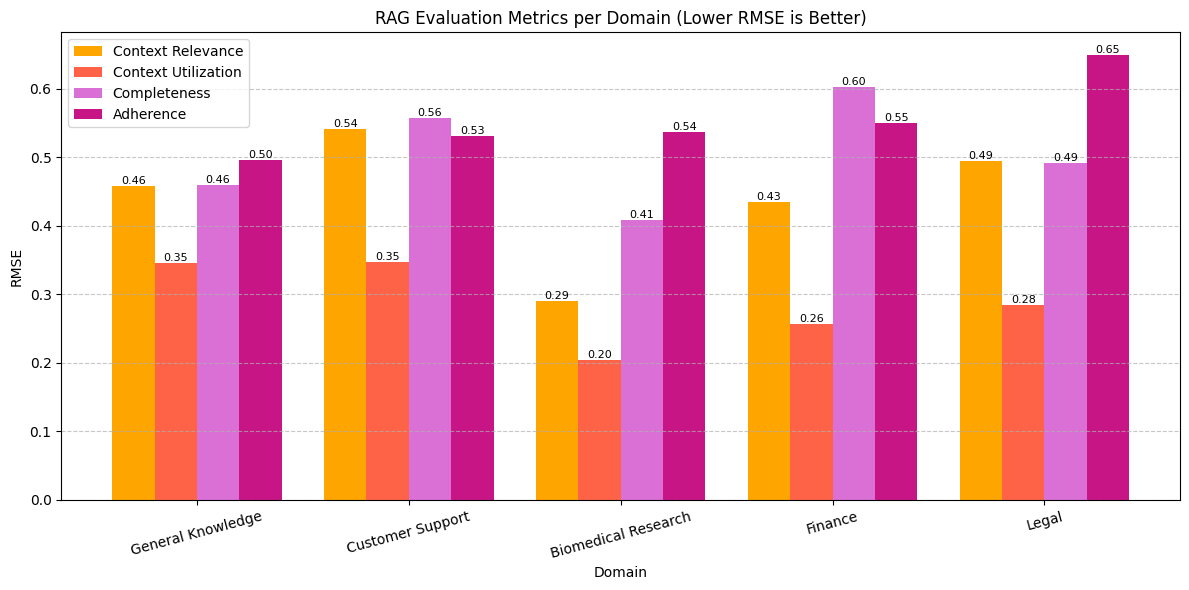

In [ ]:
plot_evaluation_summary("rag_evaluation_summary.csv")